In [103]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = [14, 7]
warnings.filterwarnings("ignore")

df = pd.read_csv('merged1538990253.771527.csv')

In [104]:
df.head()

,tweet_id,Unnamed: 0,created_at,handle,mined_at,retweet_count,text
0,1048727214253113349,0,Sun Oct 07 00:10:26 +0000 2018,superwoman⚔,2018-10-06 21:10:50.788029,2218,RT @OJARDELITO: *PESQUISA - VÉSPERA DA ELEIÇÃO...
1,1048727190899232768,1,Sun Oct 07 00:10:21 +0000 2018,Alan Izaias Garus Prodelik,2018-10-06 21:10:50.788029,0,"Com os números recentes do Ibope e Datafolha,..."
2,1048727190437879808,2,Sun Oct 07 00:10:21 +0000 2018,Rodrigo,2018-10-06 21:10:50.788029,239,RT @congemfoco: Nossa opinião: a dupla Bolsona...
3,1048727185643720704,3,Sun Oct 07 00:10:20 +0000 2018,Gomes Miguel,2018-10-06 21:10:50.788029,668,RT @TSEjusbr: Quem registrar o voto com máquin...
4,1048727170594607110,4,Sun Oct 07 00:10:16 +0000 2018,⚜ TelBoni 🌞,2018-10-06 21:10:50.788029,0,"Mano. Meu. Paulista come cocô mesmo, PSDB ajud..."


In [105]:
df.shape

(271247, 7)

In [106]:
from datetime import datetime, timezone

def twitterdate_to_datetime(twitterdate):
    return datetime.strptime(twitterdate, '%a %b %d %X %z %Y').replace(tzinfo=timezone.utc).astimezone(tz=None)
    
def datetime_to_integer(datetime):
    return round(datetime.timestamp())

df['created_at'] = df['created_at'].map(twitterdate_to_datetime)
df['created_at_int'] = df['created_at'].map(datetime_to_integer)
df['created_at_day'] = df['created_at'].map(lambda x: x.day)
df['created_at_hour_int'] = df['created_at'].map(lambda x: x.time().hour)
df['created_at_hour_float'] = df['created_at'].map(lambda x: x.time().hour + (x.time().minute * x.time().second) / 3600)

df_day = df[df['created_at_day'] == 7]

In [107]:
df.head()

,tweet_id,Unnamed: 0,created_at,handle,mined_at,retweet_count,text,created_at_int,created_at_day,created_at_hour_int,created_at_hour_float
0,1048727214253113349,0,2018-10-06 21:10:26-03:00,superwoman⚔,2018-10-06 21:10:50.788029,2218,RT @OJARDELITO: *PESQUISA - VÉSPERA DA ELEIÇÃO...,1538871026,6,21,21.072222
1,1048727190899232768,1,2018-10-06 21:10:21-03:00,Alan Izaias Garus Prodelik,2018-10-06 21:10:50.788029,0,"Com os números recentes do Ibope e Datafolha,...",1538871021,6,21,21.058333
2,1048727190437879808,2,2018-10-06 21:10:21-03:00,Rodrigo,2018-10-06 21:10:50.788029,239,RT @congemfoco: Nossa opinião: a dupla Bolsona...,1538871021,6,21,21.058333
3,1048727185643720704,3,2018-10-06 21:10:20-03:00,Gomes Miguel,2018-10-06 21:10:50.788029,668,RT @TSEjusbr: Quem registrar o voto com máquin...,1538871020,6,21,21.055556
4,1048727170594607110,4,2018-10-06 21:10:16-03:00,⚜ TelBoni 🌞,2018-10-06 21:10:50.788029,0,"Mano. Meu. Paulista come cocô mesmo, PSDB ajud...",1538871016,6,21,21.044444


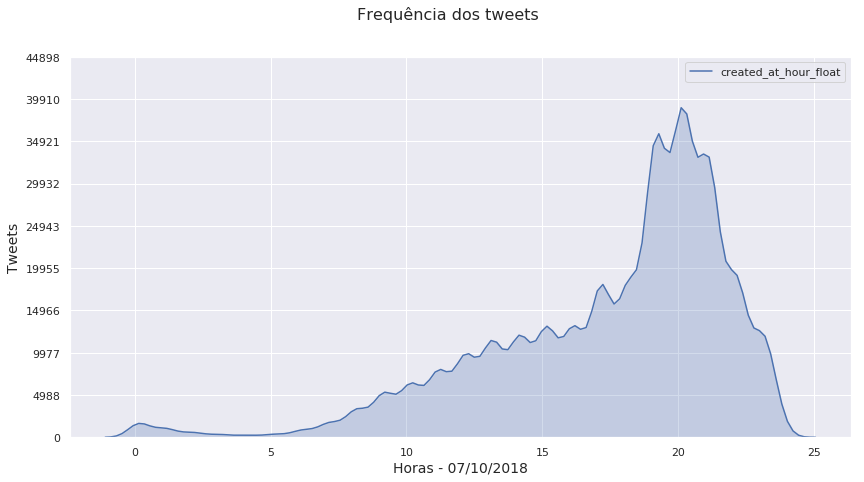

In [108]:
fig = sns.kdeplot(df_day['created_at_hour_float'], shade=True)

fig.figure.suptitle("Frequência dos tweets", fontsize = 16)

plt.xlabel('Horas - 07/10/2018', fontsize=14)

plt.ylabel('Tweets', fontsize=14)
plt.yticks(fig.get_yticks(), (fig.get_yticks() * df_day.shape[0]).astype(int))
plt.show()

In [109]:
def kdeplot_by_keywords(keyword_matrix):
    legends = []
    
    for keywords in keyword_matrix:
        sub_df = df_day[df_day['text'].str.contains('|'.join(keywords), regex=True, case=False)]
        fig = sns.lineplot(data=sub_df['created_at_hour_int'].value_counts())
        legends.append(', '.join(keywords))
    
    fig.figure.suptitle('Ocorrências de palavras-chaves', fontsize = 16)

    plt.xlabel('Horas - 07/10/2018', fontsize=14)
    plt.ylabel('Ocorrências', fontsize=14)
    plt.legend(legends)


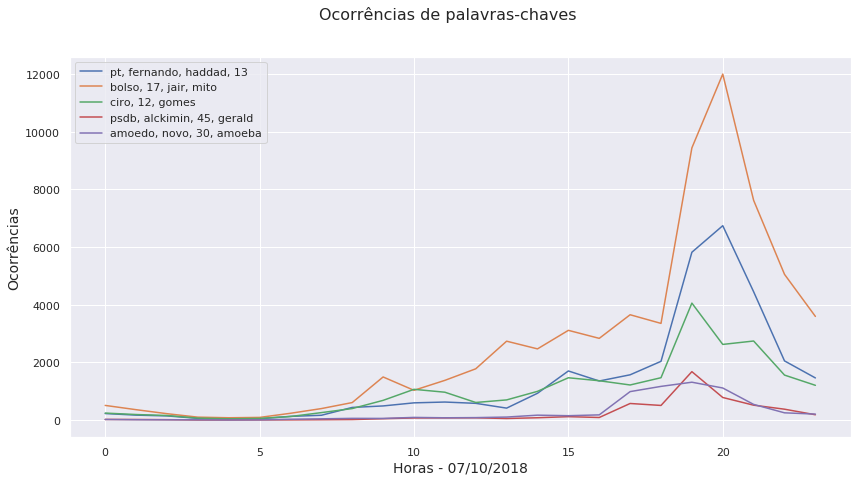

In [110]:
kdeplot_by_keywords([['pt', 'fernando', 'haddad', '13'], ['bolso', '17', 'jair', 'mito'], ['ciro', '12', 'gomes'], ['psdb', 'alckimin', '45', 'gerald'],['amoedo', 'novo', '30', 'amoeba']])

In [111]:
def kdeplot_by_keywords_timegap(keyword_matrix, min_gap, max_gap):
    legends = []
    
    _df_day = df_day[(df_day['created_at_hour_int'] >= min_gap) & (df['created_at_hour_int'] <= max_gap)]
     
    for keywords in keyword_matrix:
        sub_df = _df_day[_df_day['text'].str.contains('|'.join(keywords), regex=True, case=False)]
        fig = sns.lineplot(data=sub_df['created_at_hour_int'].value_counts())
        legends.append(', '.join(keywords))
    
    fig.figure.suptitle('Ocorrências de palavras-chaves', fontsize = 16)

    plt.xlabel('Horas - 07/10/2018', fontsize=14)
    plt.ylabel('Ocorrências', fontsize=14)
    plt.legend(legends)

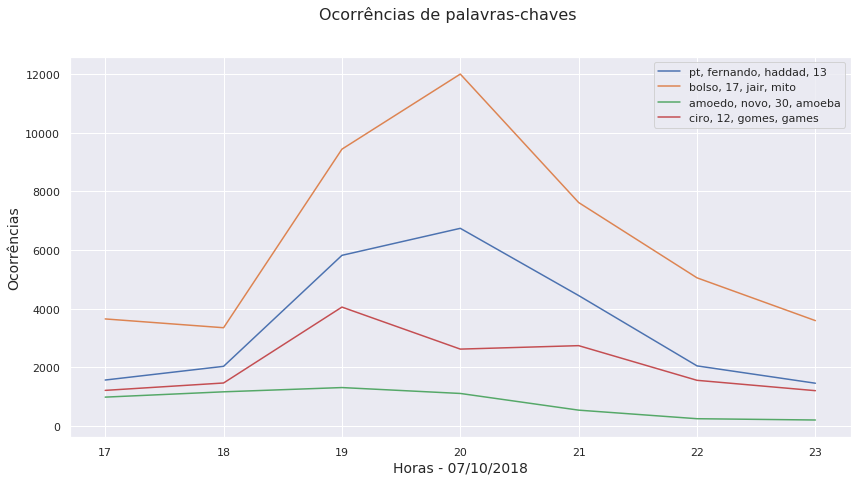

In [112]:
kdeplot_by_keywords_timegap([['pt', 'fernando', 'haddad', '13'], ['bolso', '17', 'jair', 'mito'], ['amoedo', 'novo', '30', 'amoeba'], ['ciro', '12', 'gomes', 'games']], 17, 24)

In [113]:
from collections import Counter

def generate_counter_timegap(min_gap, max_gap):
    arr = []
    _df_day = df_day[(df_day['created_at_hour_int'] >= min_gap) & (df['created_at_hour_int'] <= max_gap)]
    _df_day['text'].map(lambda x: list(map(lambda _x: arr.append(_x), filter(lambda x: x.isalpha() or x == ' ', x.split(' ')))))
    
    return Counter(arr), arr

In [114]:
c, arr = generate_counter_timegap(0, 24)

In [115]:
c.most_common(10)

[('RT', 182771),
 ('de', 107386),
 ('o', 78522),
 ('e', 72709),
 ('a', 64620),
 ('que', 62241),
 ('em', 51183),
 ('no', 50146),
 ('do', 47817),
 ('é', 41576)]

(-0.5, 799.5, 599.5, -0.5)

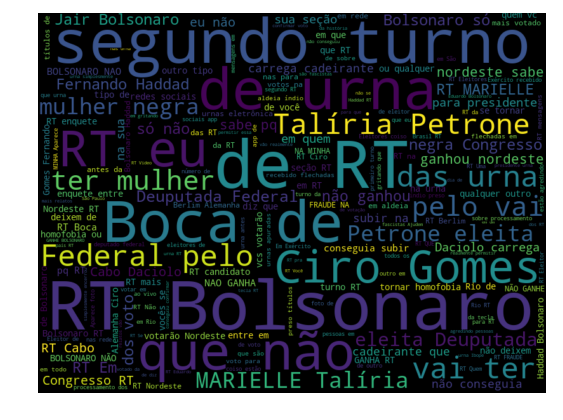

In [116]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=600)
wordcloud.generate(' '.join(arr))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")